In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import AveragePooling2D, Conv2D
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

2025-07-18 15:21:47.130449: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs: 1


# **Convolutional autoencoder for image denoising**

# Objective: Develop a convolutional autoencoder model that can effectively remove noise from corrupted images and restore them to their original clean state.

# 1. Noisy images with random Gaussian noise added

# 2. Images are grayscale with dimensions 28x28x1

# 3. Training data consists of MNIST images


In [ ]:
'''
Contains 70,000 grayscale images of handwritten digits (0-9)
Split into 60,000 training images and 10,000 test images
Each image is 28x28 pixels in size
'''

In [32]:
'''
Function to add random Gaussian noise to images
Input: Array of images (normalized between 0-1)
Output: Array of noisy images (clipped between 0-1)

The function adds controlled random noise to each image by:
1. Generating random noise from a normal distribution
2. Scaling the noise by a noise factor
3. Adding the scaled noise to the original images
4. Clipping values to maintain the [0,1] range
'''
def noise(array):
    """Adds random noise to each image in the supplied array."""

    # Control amount of noise to add
    # Higher value = more noise, 0.4 provides good balance
    noise_factor = 0.2

    # Generate and add noise to images:
    # - np.random.normal generates random values from normal distribution
    # - loc=0.0: mean of the normal distribution
    # - scale=1.0: standard deviation of the distribution
    # - size=array.shape: generate noise matching input dimensions
    # - noise_factor scales the magnitude of the noise
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0,
        scale=1.0,
        size=array.shape
    )

    # Clip the noisy pixel values to be between 0 and 1
    # This maintains valid image data range after adding noise
    return np.clip(noisy_array, 0.0, 1.0)



def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [33]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train.astype("float32") / 255.0, X_test.astype("float32") / 255.0
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


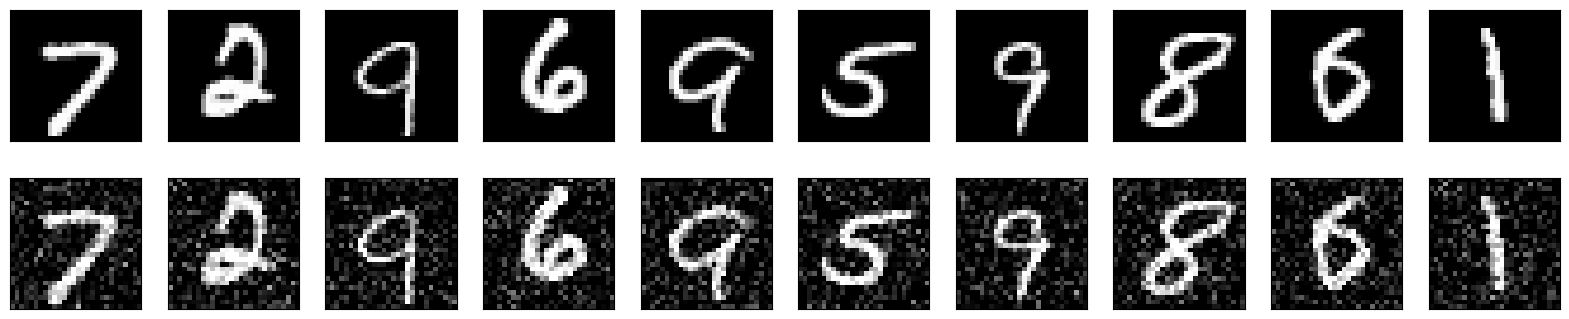

In [53]:
# Create a copy of the data with added noise
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_test)

# Display the train data and a version of it with added noise
display(X_test, noisy_test_data)

First step: Develop an AE model that can efficiently reconstruct clean images from clean images

In [ ]:
'''
The Keras Functional API provides a flexible and powerful way to build complex neural network architectures

Treats layers as functions that can be called on tensors (such as output of previous layer) to create new tensors
Provides explicit control over how layers connect and how data flows through the model
The Functional API allows creating models with non-linear topology, shared layers, and multiple inputs/outputs

https://keras.io/api/models/model/
https://www.scaler.com/topics/tensorflow/functional-api/

'''

In [49]:
from tensorflow.keras import models, layers

'''
Autoencoder Architecture:
- Input: Images of shape (28,28,1)
- Encoder: Compresses input using Conv2D and MaxPooling layers
- Decoder: Reconstructs input using Conv2DTranspose layers
- Output: Reconstructed images of shape (28,28,1)

The model is built using Keras Functional API which allows:
- More flexibility in defining complex architectures
- Multiple inputs/outputs
- Layer sharing
- Non-sequential layer connections
'''

# Define the input layer using Functional API
# Shape (28,28,1) represents grayscale images of size 28x28

input = layers.Input(shape=(28, 28, 1))

'''
Encoder Network:
- Uses Conv2D layers to learn features/patterns
- Uses MaxPooling to reduce spatial dimensions
- Progressively compresses the input into a lower-dimensional representation
'''
# First Conv + Pool block
# 32 filters of size 3x3, ReLU activation
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
# Reduce spatial dimensions by half (28x28 -> 14x14)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Second Conv + Pool block
# Further feature extraction and dimension reduction
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# Further reduce dimensions (14x14 -> 7x7)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

'''
Decoder Network:
- Uses Conv2DTranspose layers for upsampling
- Progressively increases spatial dimensions
- Reconstructs the original input dimensions
'''
# First upsampling block
# Increase dimensions (7x7 -> 14x14)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

# Second upsampling block
# Increase dimensions (14x14 -> 28x28)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

# Output layer
# Generate final image with same dimensions as input
# Sigmoid activation ensures output values between 0 and 1
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

'''
Create the model using Functional API:
- Specify input and output tensors
- Model automatically builds the graph of layers
'''
autoencoder = Model(input, x)

# Compile the model:
# - Adam optimizer for efficient training
# - Binary crossentropy loss for pixel-wise reconstruction
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Display model architecture summary
autoencoder.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 14, 14, 32)       924

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5,
    restore_best_weights = True
    )

autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=70,
    batch_size=128,
    shuffle=True,
    callbacks=[callback],
    validation_data=(X_test, X_test),
)


Epoch 1/70
469/469 [==============================] - 2s 4ms/step - loss: 0.1315 - val_loss: 0.0724
Epoch 2/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0710 - val_loss: 0.0692
Epoch 3/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0689 - val_loss: 0.0677
Epoch 4/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0679 - val_loss: 0.0669
Epoch 5/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0671 - val_loss: 0.0664
Epoch 6/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0666 - val_loss: 0.0659
Epoch 7/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 8/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0658 - val_loss: 0.0652
Epoch 9/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0655 - val_loss: 0.0649
Epoch 10/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0652 - val_loss: 0.0646

313/313 [==============================] - 0s 1ms/step


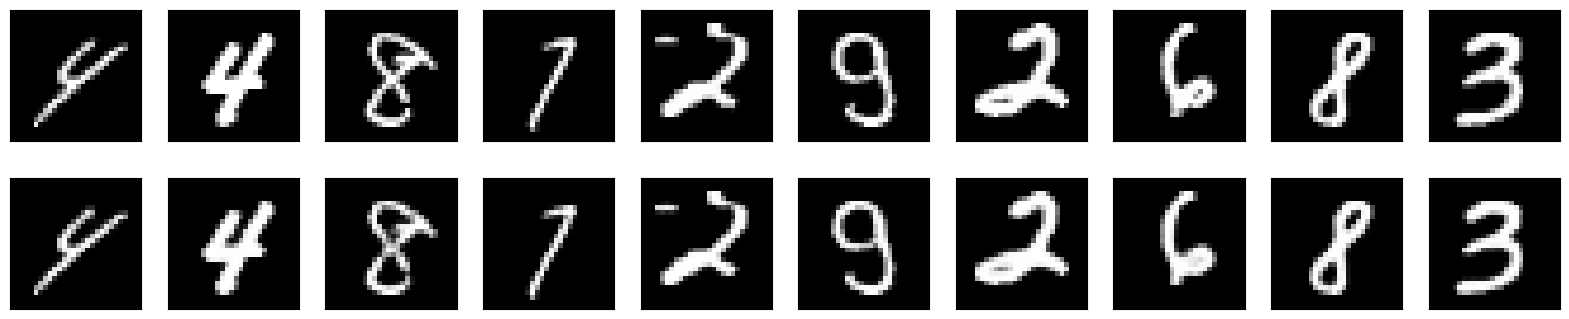

'\nClean test images are provided as input\nClean image is reconstructed or predicted by the AE\n'

In [51]:
predictions = autoencoder.predict(X_test)
display(X_test, predictions)

'''
Clean test images are provided as input
Clean image is reconstructed or predicted by the AE
'''


313/313 [==============================] - 0s 1ms/step


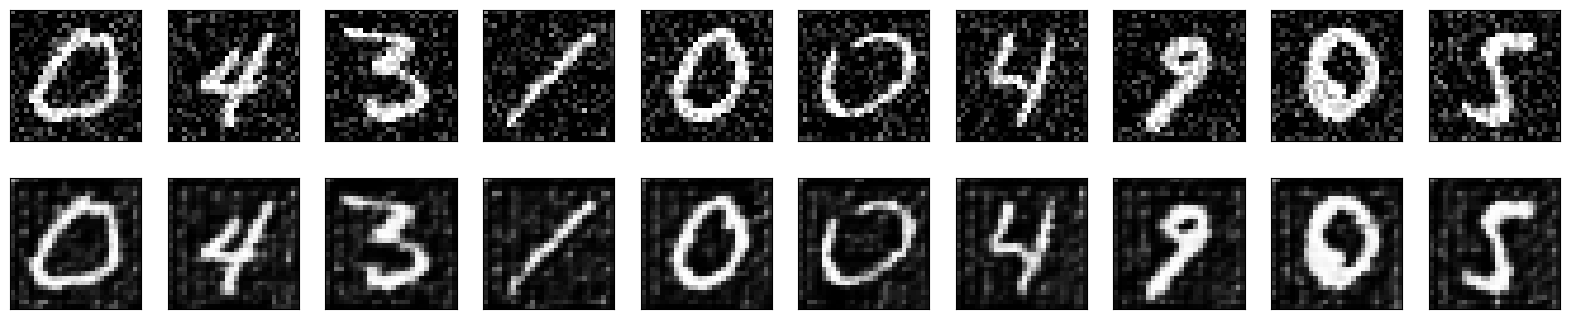

In [52]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

In [45]:
from tensorflow.keras import models, layers

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x=  layers.Flatten()(x)
x=  layers.Dense(100, activation='relu')(x)
x=  layers.Dense(7*7*32, activation='relu')(x)
x=  layers.Reshape((7,7,32))(x)
# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1568)              0  

Now we can train the autoencoder using the same image for input and target, during both training and validation (The test data is used for validation)

In [46]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5,
    restore_best_weights = True
    )
autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=70,
    batch_size=128,
    shuffle=True,
    callbacks=[callback],
    validation_data=(X_test, X_test),
)


Epoch 1/70
469/469 [==============================] - 3s 5ms/step - loss: 0.1769 - val_loss: 0.0977
Epoch 2/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0906 - val_loss: 0.0836
Epoch 3/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0821 - val_loss: 0.0796
Epoch 4/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0785 - val_loss: 0.0768
Epoch 5/70
469/469 [==============================] - 2s 5ms/step - loss: 0.0763 - val_loss: 0.0750
Epoch 6/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0747 - val_loss: 0.0735
Epoch 7/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0735 - val_loss: 0.0724
Epoch 8/70
469/469 [==============================] - 2s 5ms/step - loss: 0.0726 - val_loss: 0.0716
Epoch 9/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0718 - val_loss: 0.0710
Epoch 10/70
469/469 [==============================] - 2s 4ms/step - loss: 0.0712 - val_loss: 0.0713

313/313 [==============================] - 1s 2ms/step


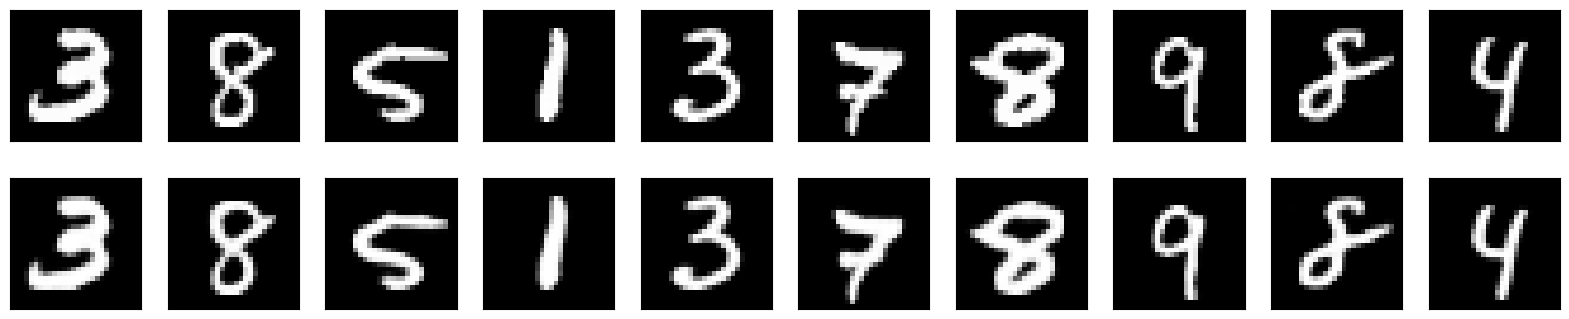

'\nClean test images are provided as input\nClean image is reconstructed or predicted by the AE\n'

In [47]:
predictions = autoencoder.predict(X_test)
display(X_test, predictions)

'''
Clean test images are provided as input
Clean image is reconstructed or predicted by the AE
'''


313/313 [==============================] - 1s 2ms/step


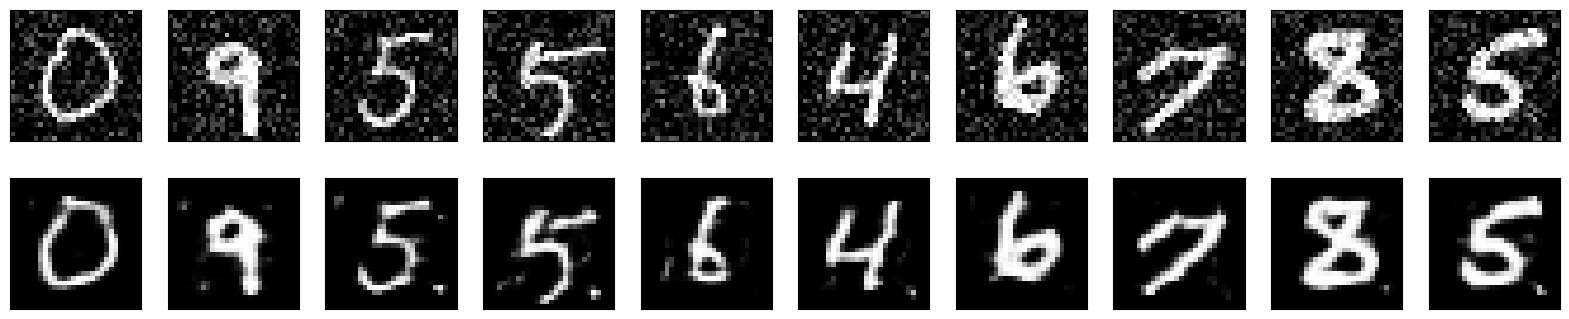

In [48]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)